Alexander S. Lundervold, August 27th, 2018

# Introduction

This is a walkthrough of some key concepts in machine learning, illustrated using a simple regression problem. 

It's not important that you understand the details at first. Many of the new concepts may be a bit hard to grasp immediately, and the code unfamiliar. *That's not a problem!* You should return to this notebook later in the course. Things will be clearer then. For now, focus on getting the gist of what's going on. 


The notebook is based on Chapter 1 of [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book) by C.M. Bishop. (A book that's highly recommended if you want a more theoretical introduction to machine learning!)

# Setup

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Problem description

We're in a situation where we're observing input values $x$ and want to predict corresponding output values $t$. *This kind of situation covers almost everything we'll encounter in practice!* It's all about predicting the correct output from given inputs. 

Say that the function generating $t$'s from $x$'s is 

$$t = \sin(2\pi x).$$

In code:

In [4]:
def f(x):
    return np.sin(2*np.pi*x)

As a graph:

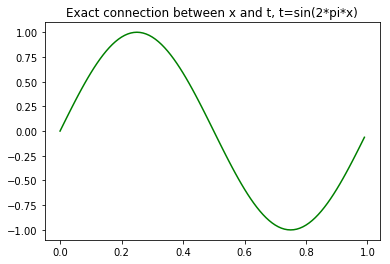

In [5]:
X_exact = np.arange(0.0, 1.0, 0.01)
plt.plot(X_exact, f(X_exact), 'g')
plt.title("Exact connection between x and t, t=sin(2*pi*x)")
plt.show()

That is, we assume that we know the underlying data generating process precisely. This makes it easier to explain the methods and compare results. However, this is not the usual situation. *Typically our data is generated by some unknowable function or process that we have to discover through machine learning.*

We'll go ahead and pretend that we don't know the connection between $x$ and $t$, and try to discover it using machine learning methods. The methods are based on a set of observations called the **training data**. These are pairs of input-outputs:

- Observations of inputs: $\mathbf{X} = (x_1, x_2, \dots, x_N)$
- Observations of outputs: $\mathbf{y} = (y_1, y_2, \dots, y_N)$.

We generate our outputs from the above sine function, but with some added noise:

In [6]:
def generate_data(N, sigma, seed=42):
    """
    Generate N data points sampled uniformly at random , 
    with noise added to the labels (sampled from the 
    normal distribution with standard deviation sigma). 
    Seed set to 42 by default.
    Return: X, y
    """
    np.random.seed(seed)
    
    # Random values between 0 and 1 sampled uniformly
    X = np.random.rand(N)
    
    # Corresponding values of T, with some added noise
    y = f(X) + sigma*np.random.randn(N)
    
    return X, y

We'll use `N` training data points, with a noise level specified by `sigma`:

In [7]:
N_train = 10
sigma=0.2

In [8]:
X_train, y_train = generate_data(N=N_train, sigma=sigma)

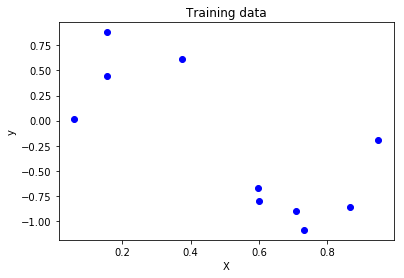

In [9]:
plt.plot(X_train, y_train, 'bo')
plt.xlabel('X')
plt.ylabel('y')
plt.title("Training data")
plt.show()

Let's plot the training data on top of the exact values to better illustrate the situation we're in:

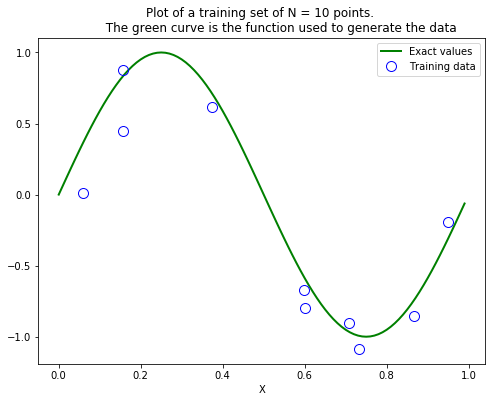

In [10]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X_exact, f(X_exact), 'g', linewidth=2, 
        label='Exact values')
ax.plot(X_train, y_train, 'bo', markersize=10, 
        fillstyle='none', label='Training data')

plt.xlabel('X')
plt.title(f'''Plot of a training set of N = {N_train} points. 
          The green curve is the function used to generate the data''')

ax.legend()
plt.show()

This is a very common situation: you'll have a bunch of data points generated by an (unknown) **underlying process**, with some **noise** or **uncertainties**. The data points can be images, sounds, sales data from a store, patient journals from a hospital, measurements from a laser, whatever. 

There are many possible sources of uncertainty, often things we cannot model precisely. Perhaps inherent uncertainty in the phenomenon. Or uncertainty caused by a measuring instrument. Or irreversible noise caused by data compression or some other process we cannot control. 

> **Goal**: Use the training data to predict output values given *new* values of $x$. 

In other words, try to find &ndash; or more realistically, **approximate** &ndash; the underlying data generating function. 

# How to solve it: an idea

Let's attack the problem by using **polynomials**. We'll try to find polynomials that fit "best" with the training data. 

More precisely, we'll use functions of the form

$$P(x, \mathbf{w}) = w_0 + w_1 x + w_2 x^2 + \cdots + w_M x^M$$

that we tune to the training data we've been given.

Here $\mathbf{w}$ are the *coefficients* of the polynomial, and $M$ is its *degree*. We want to find the values of $\mathbf{w}$ and $M$ that gives us the 
> **best predictions for new, previously unseen values of $x$**.

There are two things we can tune, i.e. two parameters in our model: $\mathbf{w}$ and $M$. 

> What do we mean by "best"?

Let's think about that by first trying to fit the training data using a fixed value of the degree $M$. 

## Measuring the error

We can measure how well a polynomial fits the training data by measuring the **approximation error**. A convenient error function for regression problems is the **sum of squared errors** between the predictions $P(x_n, \mathbf{w})$ for each data point $x_n$ and the corresponding output values $t_n$:

$$E(\mathbf{w}) = \sum_{n=1}^N \big(P(x_n, \mathbf{w}) - t_n \big)^2$$

Notice that $E=0$ exactly when the polynomial passes through *all* the training data points $(x_n , t_n)$. The error is zero when the approximation is perfect. 

Error functions are sometimes also called **cost functions**. They computer the *cost* of using the current parameters of the model (the weights, in our case). 

Here's the same function in code:

In [11]:
def error(P, x, t):
    """
    Computes the sum of squared errors when using y to 
    approximate the true values t at the points x
    """
    
    return np.sum( (P(x) - t)**2 )

By setting the derivative of $E$ to zero, trying to find the values of $\mathbf{w}$ that minimize $E$ (MAT100 style), it turns out that it's possible to exactly determine the values of $\mathbf{w}$ that minimize the error. If you're curious about the details, have a look look [here]() for a sketch of how it's done.

Here are some plots of polynomials of varying degree $M$ that all minimize $E$:

In [12]:
def plot_poly_approx(degree, title=""):

    #X values used to plot the polynomial:
    x_poly = np.linspace(0,1,100)
    # Corresponding values of the polynomial:
    y_poly = P(x_poly)
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.plot(X_exact, f(X_exact), 'g', label='Exact values')
    ax.plot(X_train, y_train, 'bo', label="Training data")
    ax.plot(x_poly, y_poly, 'r', label="Polynomial")
    
    ax.legend()
    
    plt.ylim(-1.5, 1.5)
    plt.title(title)
    plt.show()
    return ax

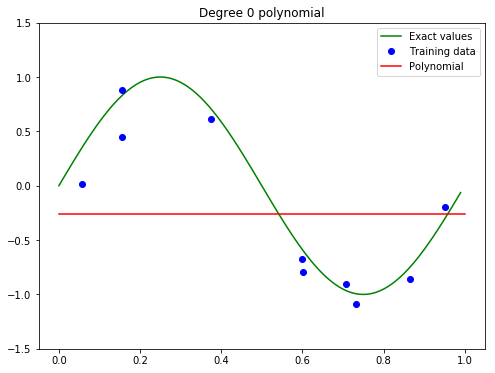

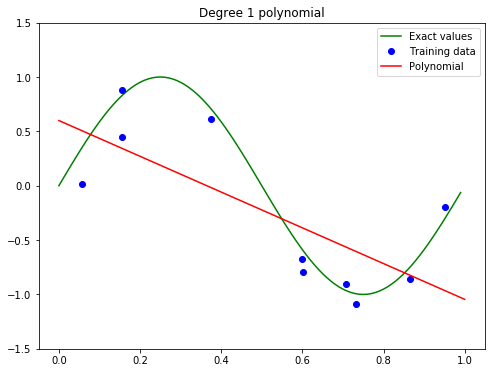

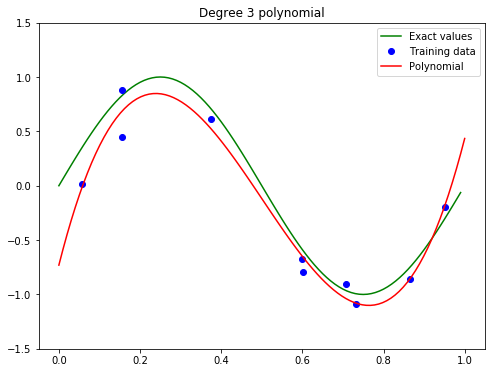

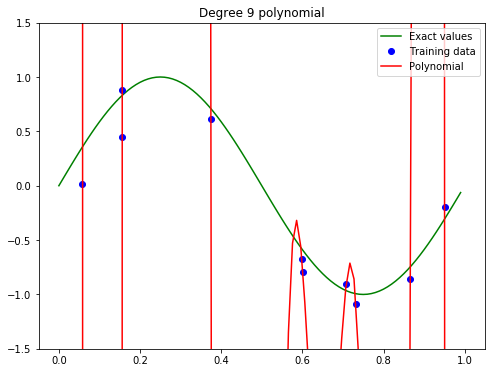

In [13]:
degrees = [0, 1, 3, 9]

for M in degrees:
    P = np.poly1d(np.polyfit(X_train, y_train, deg=M)) 
    # The above functions minimize the error E for us
    plot_poly_approx(M, title=f"Degree {M} polynomial")

We notice that the order of the polynomial makes a huge difference! 

Which model do we choose? Which one's "best"? 

For sure, $M=0$ and $M=1$ seems like bad models: they're too far from the training data points. On the other hand, $M=9$ gives us an excellent fit to the training data, with very low error. But we have the luxury of having access to the true, exact function, and its obvious that $M=9$ results in a horrible model for $\sin(2*pi*x)$...

What's happening to the high degree polynomials like $M=9$ is what's called **overfitting**, an extremely important concept in machine learning. The model *tries too hard* to fit the training data, and ends up being a bad fit to the true solution. 

Imagine we're given a new data point $x$ that's not from the training data. The model with $M=9$ will likely give a very stupid prediction for the corresponding value of $t$. It's bad at **generalization**. And generalization abilities is exactly what we're after: we want models that can give good predictions of $t$ for new, previously unseen values of $x$. We want them to perform well on data they've never seen before!

$M=3$ seems to hit a sweet spot in our case. 

> How can we make these observations more precise?

> How can we find good models when we don't have access to the true solution (which in practice is always)?

## How to measure model performance? How to find the best model?

One of the main ideas in machine learning&ndash;and the way we'll tackle these problems&ndash; is to use 
> **train, validation and test sets**

Recall (again) that our goal is to create a model that can produce accurate predictions for previously unseen data points. To estimate model performance we set aside some of our data points as a **test set** and disregard them during the training of the model. 

The test set can then be used to *simulate* what will happen when new points are put into the trained model, and to quantify its performance. 

One standard way to do this is to set aside approximately 20% of the data we've been given for testing, and use the remainder for training (using for example scikit-learn's `train_test_split` function).

In our situation we can easily produce new data since we know the data generating function, and we can leave the $N$ points we already have for training the models. However, note that in practice this is not typically how it's done since you cannot easily collect more data. You have to use what you've got.

In [14]:
# Test data
N_test = 100
X_test, y_test = generate_data(N_test, sigma, seed=0)

Here's the training and test data:

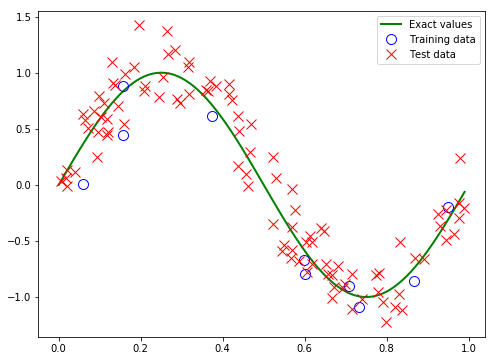

In [15]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(X_exact, f(X_exact), 'g', linewidth=2, 
        label='Exact values')
ax.plot(X_train, y_train, 'bo', markersize=10, fillstyle='none', 
        label='Training data')
ax.plot(X_test,y_test, 'rx', markersize=10, fillstyle='none', 
        label='Test data')
ax.legend()
plt.show()

Now we can plot how the polynomials perform in terms of the error function E as we increase the degree from 0 to 9. 

It's convenient (and standard) to change the error function slightly and use the **root mean square** error function:

$$\displaystyle{RMS(\mathbf{w}) = \sqrt{E(\mathbf{w})/N}}$$

(It has the advantage of dividing being in the same scale as the target variable $t$ (because of the square root). The division by $N$ lets us compare the error on data sets of different sizes.)

In [16]:
def rmserror(P, x, t):
    """
    Returns the root mean square error 
    """
    err = error(P,x,t)
    
    return np.sqrt(err/len(x))

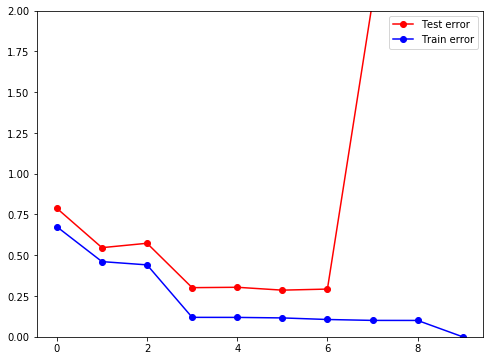

In [17]:
trainerrors = []
testerrors = []
degrees = range(0,10)
for deg in degrees:
    P = np.poly1d(np.polyfit(X_train, y_train, deg=deg))
    trainerrors.append(rmserror(P, X_train, y_train))
    testerrors.append(rmserror(P, X_test, y_test))
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(degrees, testerrors, '-ro', label="Test error")
ax.plot(degrees, trainerrors, '-bo', label="Train error")
plt.ylim(0,2)
ax.legend(loc='best')
plt.show()


Now we can see what's happening. The models with low $M$ aren't able to capture the function $\sin(2\pi x)$ and have relatively high error on the test set. The models with high $M$ have extremely low training error (as low as 0 for the polynomial of degree 9, which is able to capture the training data perfectly), but high test error.

The models in-between, say in the range $3 \leq M \leq 5$, give reasonable approximations to the training data *and* have relatively low test error. They're in the sweet spot, not underfitting and not overfitting, having good generalization capabilities. 

We've used a data set not used directly in training to find suitable values for the degree of the polynomial. The degree is a **hyperparameter** of our models: a parameter we can use to control our model that is not set by the learning algorithm itself. Setting aside a set of data points and use it to choose hyperparameters is *the* standard machine learning way, and we'll use it throughout the course.

## Overfitting versus amount of data

An important side-note is that whether a model will overfit a training data set is typically very much dependent on the size of the data set! 

If the data set is small, a complex model will tend to overfit (unless we're clever and use *regularization*, as explained below). If we increase the data set the overfitting problem will be less severe. 

Let's give it a try:

In [18]:
# Size of data set
N_train = 100
# Degree of polynomial
M = 9

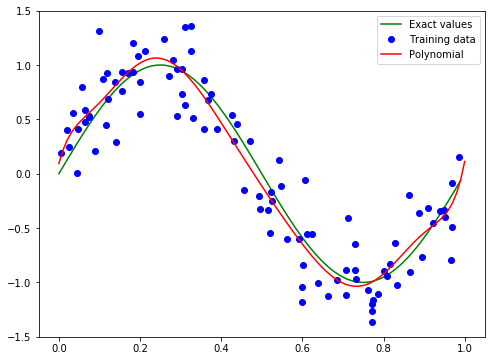

In [19]:
# Generate training data as before
X_train, y_train = generate_data(N_train, 0.3)

# Polynomial approximation
P = np.poly1d(np.polyfit(X_train, y_train, deg=M))

# Plot the data and the polynomial approximation
_ = plot_poly_approx(M)

Now the complex model gives a good approximation. Both visually, and in terms of the error:

In [20]:
rmserror(P, X_test, y_test)

0.2295847618658761

You can play around with the effect of choosing various N's and M's below:

In [21]:
def get_rmserror(N_train, M=9):
    X_train, y_train = generate_data(N_train, 0.3)
    P = np.poly1d(np.polyfit(X_train, y_train, deg=M))
    return rmserror(P, X_test, y_test)

In [22]:
from ipywidgets import interact, interactive

In [23]:
_ = interact(get_rmserror, N_train=(10,100), M=(0,15))

0.28283915244491303

Here's an interactive visualization of the effect of choosing N and M:

<Figure size 432x288 with 0 Axes>

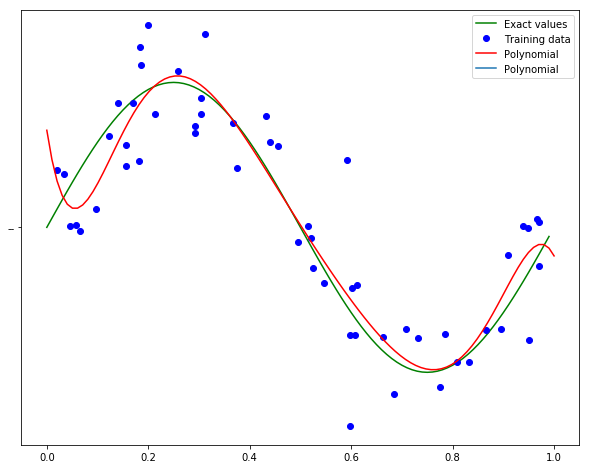

In [24]:
def generate_plot_poly_approx(N, M):
    plt.figure(2)
    X, y = generate_data(N, 0.3)
    P = np.poly1d(np.polyfit(X, y, deg=M))
    #X values used to plot the polynomial:
    X_poly = np.linspace(0,1,100)
    # Corresponding values of the polynomial:
    y_poly = P(X_poly)
    
    fig, ax = plt.subplots(figsize=(10,8))
    
    ax.plot(X_exact, f(X_exact), 'g', label='Exact values')
    ax.plot(X, y, 'bo', label="Training data")
    ax.plot(X_poly, y_poly, 'r', '--', label="Polynomial")
    
    ax.legend()
    
    plt.ylim(-1.5, 1.5)
    plt.show()

interactive_plot = interactive(generate_plot_poly_approx, N=(10, 100), M=(0, 15))
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

You notice that if the data set is small and the degree is large, you'll overfit. If the data set is large and the degree small you'll end up underfitting.

## So, how do we choose M?

Here's a plan: choose the M that gives the lowest error for the test set. 

> **That's not a good plan!** 

Why? Because by using the test set to tune the parameter $M$ then information from the test set leaks into the model construction process! The test set is to be kept totally separate, and only used for testing the final model. Otherwise, *it wouldn't provide a good simulation of the situation we're really interested in!* Which is new, previously unseen points that we're supposed to make predictions for. It could happen that by chance a certain value of $M$ is particularly good for the test set we happen to have, but very bad for new data points. That would be a model that fails to generalize well.

This is super important, and is worth repeating:
> **Keep your hands off the test set during model construction!**

If you're not careful you may end up *overfitting to the test set*. Then what do you do to estimate the model's performance? If the model fit the test set really well because we tuned it that way, there's no way of knowing how good it will be once we put it in production. 

So, what do we do? We divide the training set into *three* parts. 

> - A **training set** used to create the model
- A **validation set** used to tune parameters of the model (model selection)
- A **test set** to test the final model. The performance of the model on the test set is used as an estimate of its "true" performance. 

We'll make this split all the time throughout the course, mostly using the `train_test_split` function of scikit-learn.

Again, in our special case where we know the data generating function precisely, it's easy to generate *new* data for validation and test:

In [25]:
# Training data
N_train = 70
X_train, y_train = generate_data(N_train, sigma)

In [26]:
# Validation data
N_val = 20
X_val, y_val = generate_data(N_val, sigma, seed=0)

In [27]:
# Test data
N_test = 10
X_test, y_test = generate_data(N_test, sigma, seed=1)

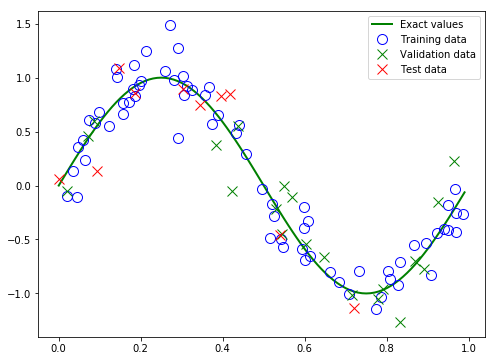

In [28]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(X_exact, f(X_exact), 'g', linewidth=2, label='Exact values')
ax.plot(X_train,y_train, 'bo', markersize=10, fillstyle='none', label='Training data')
ax.plot(X_val,y_val, 'gx', markersize=10, fillstyle='none', label='Validation data')
ax.plot(X_test,y_test, 'rx', markersize=10, fillstyle='none', label='Test data')
ax.legend()
plt.show()

We look for the model that gives the lowest validation error, and then evaluate it on the test set:

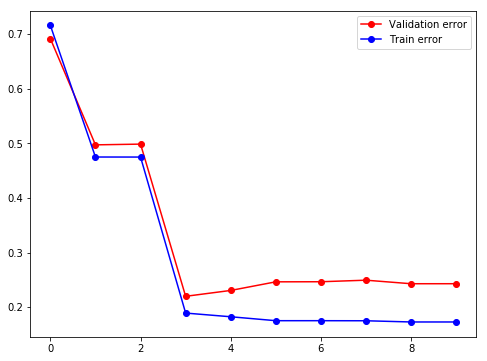

In [29]:
trainerrors = []
testerrors = []
degrees = range(0,10)
for deg in degrees:
    P = np.poly1d(np.polyfit(X_train, y_train, deg=deg))
    trainerrors.append(rmserror(P, X_train, y_train))
    testerrors.append(rmserror(P, X_val, y_val))
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(degrees, testerrors, '-ro', label="Validation error")
ax.plot(degrees, trainerrors, '-bo', label="Train error")
ax.legend(loc='best')
plt.show()

$M=3$ seems like a good choice. 

In [30]:
our_model = np.poly1d(np.polyfit(X_train, y_train, deg=3))

Test error:

In [31]:
rmserror(our_model, X_test, y_test)

0.2704528070648208

Pretty good. Let's plot the result:

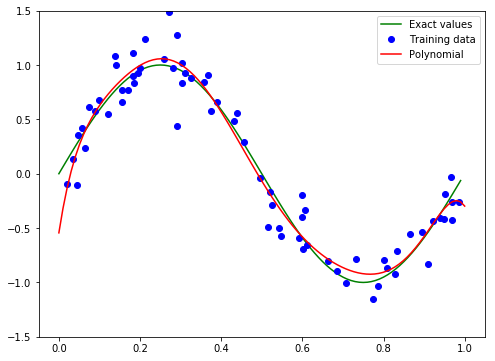

In [32]:
plot_poly_approx(5)
plt.show()

# Regularization

> Why can't complex models figure out that they're being *too complex* themselves? Why do *we* have to do it??

One of our goals in machine learning is after all to get the computers to do as much of the work as possible. That should include giving us the best models for the job. 

Luckily, the models can be made to avoid becoming too complex automatically! Using what's called **regularization**.

## Regularization

Let's have a look at the overfitting polynomial again:

In [33]:
N_train = 10
sigma=0.2

X_train, y_train = generate_data(N=N_train, sigma=sigma)

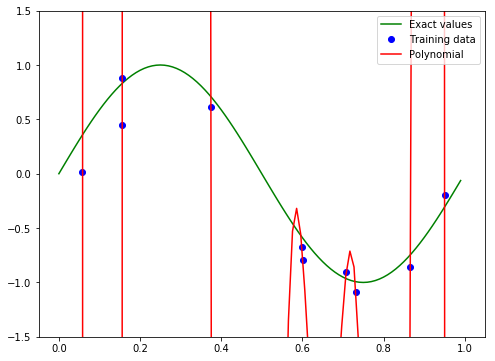

In [34]:
P = np.poly1d(np.polyfit(X_train, y_train, deg=M))
plot_poly_approx(M)
plt.show()

We can have a closer look at the 10 coefficients of P

$$w_0 + w_1 x + w_2 x^2 + \cdots + w_9 x^9$$

In [35]:
P.coefficients

array([-2.52428063e+07,  1.26612374e+08, -2.72807862e+08,  3.29392642e+08,
       -2.43526355e+08,  1.12930086e+08, -3.22430074e+07,  5.30591140e+06,
       -4.34627196e+05,  1.25259697e+04])

They're huge! That's because they're finely tuned to make the polynomial go through the training data points, without any other constraints. This makes it oscillate heavily between the points, which then makes it really bad at generalization. 

Remember that the coefficients were found by minimizing the error function 

$$E(\mathbf{w}) = \sum_{n=1}^N \big(y(x_n, \mathbf{w}) - t_n \big)^2$$

Let's add a *penalty term* to the error function which tries to force the coefficients to stay reasonably small:

$$\tilde{E}(\mathbf{w}) = \sum_{n=1}^N \big(y(x_n, \mathbf{w}) - t_n \big)^2 + \lambda |\mathbf{w}|^2$$

Remember that we're trying to minimize the error. Using the above expression this will automatically also try to minimize the size $|\mathbf{w}| = w_0^2 + \cdots + w_N^2$ of the coefficients. 

This is called **regularization**, and is used throughout machine learning. It's a way to put preferences into our models in such a way that the generalization error is reduced, but not the error on the training set.

The above number $\lambda$ governs how much importance we want to give to the regularization part compared to the sum of squares error part. 

Let's try to fit a degree 9 polynomial to our training data using regularization. We'll use `scikit-learn` to help us. Don't worry about the details in the below code for now. It'll all become familiar later!

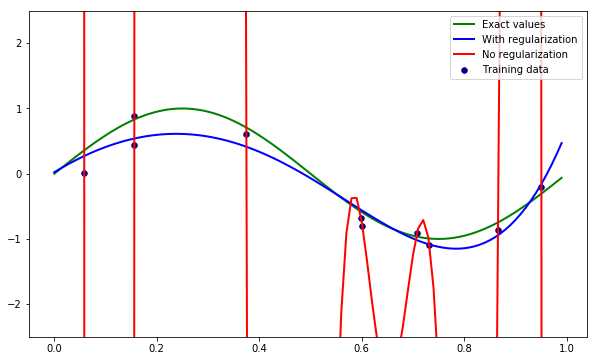

In [36]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Data
X_exact = np.arange(0.0, 1.0, 0.01)
y_exact = f(X_exact)

# Trick to make scikit-learn happy
X_train_array = X_train[:, np.newaxis]
y_train_array = y_train[:, np.newaxis]
X_exact_array = X_exact[:, np.newaxis]
y_exact_array = y_exact[:, np.newaxis]

# Plot of exact function and our training data
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(X_exact, y_exact, color='green', linewidth=2,
         label="Exact values")
plt.scatter(X_train, y_train, color='navy', s=30, marker='o', label="Training data")

# Polynomial approximation without regularization
degree=9
P = np.poly1d(np.polyfit(X_train, y_train, deg=degree))

# Polynomial approximation with regularization (using scikit-learn)
alpha = 0.001 
# alpha is the amount of regularization. 
# It's proportional to 1/lambda in the formula above

model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
model.fit(X_train_array, y_train_array)
y_pred_regr = model.predict(X_exact_array)

# Plot of the resulting polynomials
ax.plot(X_exact, y_pred_regr, color='b', linewidth=2,
             label="With regularization")
ax.plot(X_exact, P(X_exact), color='red', linewidth=2,
             label="No regularization")

plt.ylim(-2.5, 2.5)
plt.legend()

plt.show()

> **Your turn!:** 
- Try changing the amount of regularization. Try `alpha = 0`. What happens? Why? Then try `alpha = 0.1`. 
- Make a plot where the x-axis is the amount of regularization and the y-axis is the `rmserror`, showing both the training set and the test set error for the degree 9 polynomial above.

Regularization helps combat overfitting! 

We can also see this from the coefficients of the polynomial, which are now much smaller (as expected):

In [37]:
model.named_steps.ridge.coef_

array([[ 0.        ,  4.7917594 , -8.89014022, -4.11433992,  1.13493122,
         3.48798632,  3.50297831,  2.18353155,  0.28177652, -1.74292502]])

...compare with

In [38]:
P.coef

array([-2.52428063e+07,  1.26612374e+08, -2.72807862e+08,  3.29392642e+08,
       -2.43526355e+08,  1.12930086e+08, -3.22430074e+07,  5.30591140e+06,
       -4.34627196e+05,  1.25259697e+04])

**How do we select the best regularization parameter in practice?**

> Using the validation set! Never use the test set to select *any* of the parameters of your model!

> **Your turn!**
- Make a plot of the `rmserror` on the validation set for various values of the regularization parameter `alpha`. Use the plot to decide on a reasonable value for `alpha`, and test it on the test set. 

# End